# Continuous Attractor Network (CAN) Tutorial

Continuous Attractor Networks produce a single, reliable estimate from multiple, imprecise and unreliable measurements. It is able, for example, to integrate measurements of altitude from barometers, accelerometers, and ultrasonic or laser rangefinders into one result. Each sensor may generate samples at different rates and sensors may drop out at any time. Laser rangefinders are very precise but if the laser light impinges on a non-normal reflective surface, there will be no light returned to the sensor and so no measurement - this is an example of what is called a 'drop-out'. This kind of non-linearity wreaks havoc for Kalman filters which is currently the most popular approach to multi-sensor fusion.
___

## Activity Matrix

A single sensor reading or measure, such as a barometric altitude reading or a compass heading reading, is represented in a CAN not as a single value but as a probabilistic spread of values or activations called an activity matrix. The activity matrix excites or adds to neighboring nodes in the CAN but inhibit or subtract from nodes farther away. In this way, a single maximal value emerges. In one dimension, the activity matrix exists as a discrete, one dimensional Marr function consisting of an excitatory gaussian function (excite_y) subtracting a same-mean, greater-variance inhibitory gaussian function (inhibit_y).

The activity matrix, shown in black below, is centered at the 18th node. This could represent a value of 18 or it could represent some multiple or fraction of 18.

CAN_SIZE:36, MIN_VALUE:0, MAX_VALUE:35
SAMPLE_READING:18, STD:2, INHIBITORY_VAR_MULT:3


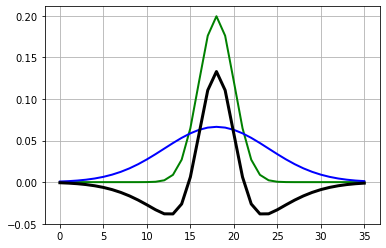

In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

CAN_SIZE = 36
MIN_VALUE = 0
MAX_VALUE = 35
print ("CAN_SIZE:{}, MIN_VALUE:{}, MAX_VALUE:{}".format(CAN_SIZE, MIN_VALUE, MAX_VALUE))
SAMPLE_READING = 18
STD = 2
INHIBITORY_VAR_MULT = 3
print("SAMPLE_READING:{}, STD:{}, INHIBITORY_VAR_MULT:{}".format(SAMPLE_READING, STD, INHIBITORY_VAR_MULT))

# Create an activity matrix
x = np.linspace(MIN_VALUE, MAX_VALUE, CAN_SIZE)
excite_y = ss.norm.pdf(x, SAMPLE_READING, STD)
inhibit_y = ss.norm.pdf(x, SAMPLE_READING, STD * INHIBITORY_VAR_MULT)
activ_matrix = excite_y - inhibit_y

# Plot the activity maxtrix
fig, ax = plt.subplots(1, 1)
ax.plot(x, excite_y,'green', lw=2)
ax.plot(x, inhibit_y,'blue', lw=2)
ax.plot(x, activ_matrix,'black', lw=3)
plt.grid(True)
plt.show()
    

Note that the activity matrix appears to be a continuous value - it is not. The angularity you see is because this activity matrix is approximated by 36 descrete values. Even though activity matrices and CANs are implemented as discrete neural networks (where each node represents a value), that does not mean that their estimates need be discrete. One can interpolate precise, continuous values from multiple discrete samples.

If you are new to python and numpy, the code above may appear unintuitive. That is because Numpy is a library that allows one to treat arrays, such as excite_y and inhibit_y as linear objects. When you subtract inhibit_y from excite_y, you are creating a new array, activ_matrix, consisting of the differences of individual array elements.
___
## Data Fusion

Continuous Attractor Networks create an estimate from multiple sensors by summing the activation matrices of each sensor sample. The peak value of this summation becomes the resulting estimate. This is illustrated below given the following hypothetical data values from three different sensors. Note that each sensor has a characteristic standard deviation or measure of uncertainty. Precise sensors such as laser rangefinders have a low standard deviation with narrow distributions. Less precise sensors, such as altitude measured from barometric pressure, will have a higher standard deviation and so a wider distribution.

* Sensor 1=24, Std=2.5, Color=red
* Sensor 2=22, Std=5.7, Color=green
* Sensor 3=27.5, Std=2, Color= blue

For this example, we assume that all measurements are updated at the same rate. The sum of all three activity matrices is shown in black. The estimated value given the three samples is the maximum value of the sum of all activity matrices.

Estimated value from three measurements is 26


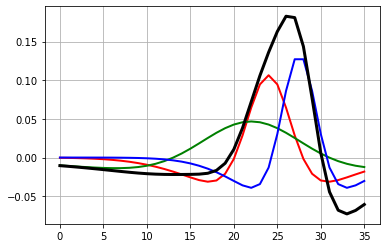

In [5]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

def activity_matrix(value, std, min, max, size):
    x = np.linspace(min,max,size)
    ey = ss.norm.pdf(x, value, std)
    iy = ss.norm.pdf(x, value, std * 3)
    return x, ey-iy

if __name__ == "__main__":
    CAN_SIZE = 36
    MIN = 0
    MAX = 35
    data = [(24, 2.5),(22,5.7),(27.5,2)]
    colors = ['red', 'green', 'blue']
    
    fig, ax = plt.subplots(1, 1)
    can = np.zeros(CAN_SIZE, dtype=float)
    i = 0
    for d in data:
        x, y = activity_matrix(d[0], d[1], MIN, MAX, CAN_SIZE)
        ax.plot(x, y,colors[i], lw=2)
        can += y
        i += 1
    
    # Calculate maximum value of CAN
    max_value = max(can)
    max_indices = np.where(can == max_value)
    max_index = max_indices[0][0]

    # Print estimate and plot values
    print("Estimated value from three measurements is {}".format(max_index)) 
    ax.plot(x, can,'black', lw=3)
    plt.grid(True)
    plt.show()
    fig.savefig('input3can.svg')

___
## Ring Attractor Network

Unlike multirotors, honey bees do not sense altitude (nor do they need to). However, they are wonderful navigators and every navigator - including us - requires a means of estimating heading. We can think of heading as a compass direction that ranges from zero  360 degrees - though, to be clear, honey bees and human brains do not know anything about 'degrees' or '360'. To create a CAN for heading, we only need to link each end of our linear CAN above together to form a ring and to insure that the link is continuous. We now have a ring attractor. We can change the value of CAN_SIZE and observe the slow change in accuracy.

For this demonstration, we will fuse data from three heading sensors:
* Sensor 1=-12, Var=12.5, Color=red
* Sensor 2=15, Var=8, Color=green
* Sensor 3=5, Var=17, Color= blue

Estimated value from three measurements is 13.0


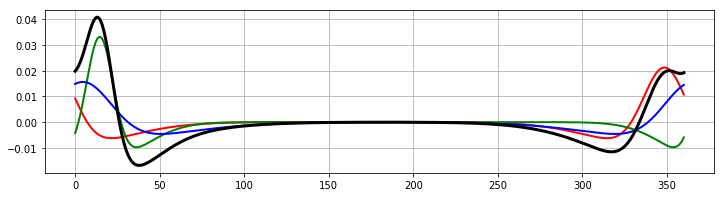

In [5]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

def ring_activity_matrix(heading, std, size):
    """
    Since zero degrees is identical to 360 degrees, we cannot
    simply chop off the activity matrix at either end of the CAN
    like we did before. So we will create each activity matrix at
    the 180 degree mark and then slide or roll them into their 
    correct heading position prior to adding to the CAN.
    """
    unit = 360 / size
    x = np.linspace(0, 360/unit, size)
    ey = ss.norm.pdf(x, 180/unit, std/unit)
    iy = ss.norm.pdf(x, 180/unit, (std/unit) * 3)
    shift = int(((180/unit) + heading))
    am = np.roll(ey-iy, shift)
    return x, am

if __name__ == "__main__":
    CAN_SIZE = 360
    unit = 360 / CAN_SIZE
    MIN = 0
    MAX = 360
    data = [(-12, 12.5), (15, 8), (5, 17)]
    colors = ['red', 'green', 'blue']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 3)
    can = np.zeros(CAN_SIZE, dtype=float)
    i = 0
    for d in data:
        # account for negative values
        if d[0] < 0:
            normalized_measure = (d[0] + 360)/unit
        else:
            normalized_measure = d[0]/unit
        normalized_std = d[1]/unit
        x, y = ring_activity_matrix(normalized_measure, normalized_std, CAN_SIZE)
        ax.plot(x, y * unit, colors[i], lw=2)
        can += y
        i += 1
        
    max_value = max(can)
    max_indices = np.where(can == max_value)
    max_index = max_indices[0][0] * unit
    print("Estimated value from three measurements is {}".format(max_index))
    
    ax.plot(x, can,'black', lw=3)
    plt.grid(True)
    plt.show()

What we observe above is that the activity matrix is wrapping around the North point of the compass. Our estimate from three measurements is 13 degrees for a ring attractor of 360 nodes. If we reduce the number of nodes, we still get a pretty good estimates:

* 13 degrees, 360 nodes
* 12 degrees, 180 nodes
* 8 degrees, 90 nodes
* 8 degrees, 45 nodes
* -24 degrees, 15 nodes
___
## Successive Measurements

What about recurring measurements that come at some later time? If we were to simply repeat the operation as above, we would be throwing away potentially useful information from past estimates. We could keep summing values - because we are really only interested in the maximum value - but it would keep growing in an unsustainable way. Instead, we add new summations to past summations that have been normalized. We use the paramater ALPHA to determine the influence of new readings:

<pre>can = (ALPHA * y) + ((1 - ALPHA) * can)</pre>

You should modify values for CAN_SIZE, ALPHA, and dataset below to observe how the CAN reponds. Reducing ALPHA can help with very noisey data but it will increase latency.


Estimated value from reading 0 (orange) is 101.0
Estimated value from reading 1 (indigo) is 105.0
Estimated value from reading 2 (violet) is 112.0
Estimated value from reading 3 (green) is 120.0
Estimated value from reading 4 (blue) is 131.0


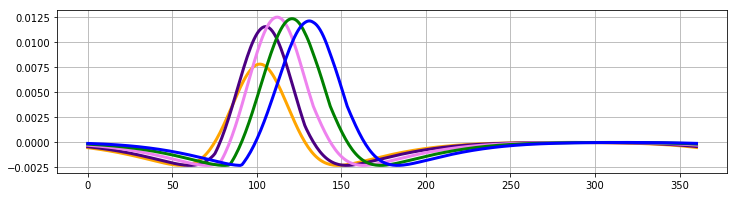

In [4]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

def ring_activity_matrix(heading, std, size):
    unit = 360 / size
    x = np.linspace(0, 360/unit, size)
    ey = ss.norm.pdf(x, 180/unit, std/unit)
    iy = ss.norm.pdf(x, 180/unit, (std/unit) * 3)
    shift = int(((180/unit) + heading))
    am = np.roll(ey-iy, shift)
    return x, am

def normalize(can):
    # The minimal value of the CAN is set to zero then its area is set to unity
    zeros = np.zeros_like(can)
    can = np.where(can <= zeros, zeros, can)
    s = np.sum(can)
    if s > 1.0:
        return can/s
    else:
        return can

if __name__ == "__main__":
    CAN_SIZE = 360
    unit = 360 / CAN_SIZE
    MIN = 0
    MAX = 360
    ALPHA = 0.5
    # Several sets of measurements
    dataset = [[(90, 12.5), (105, 8), (102, 17)],
            [(95, 12.5), (108, 8), (107, 17)],
            [(105, 12.5), (118, 8), (117, 17)],
            [(115, 12.5), (128, 8), (127, 17)],
            [(125, 12.5), (138, 8), (137, 17)]]
    colors = ['orange', 'indigo', 'violet', 'green', 'blue', 'red', 'black']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 3)
    can = np.zeros(CAN_SIZE, dtype=float)
    can_list = []
    i = 0
    for set in dataset:
        for d in set:
            # account for negative values
            if d[0] < 0:
                normalized_measure = (d[0] + 360)/unit
            else:
                normalized_measure = d[0]/unit
            normalized_variance = d[1]/unit
            x, y = ring_activity_matrix(normalized_measure, normalized_variance, CAN_SIZE)
        
        can = (ALPHA * y) + ((1 - ALPHA) * normalize(can))
        
        # Output results
        ax.plot(x, can, colors[i], lw=3)
        max_value = max(can)
        max_indices = np.where(can == max_value)
        max_index = max_indices[0][0] * unit
        print("Estimated value from reading {} ({}) is {}".format(i, colors[i], max_index))
        i += 1
    
    plt.grid(True)
    plt.show()

___
## Asynchronous Updates with Dropouts

The previous example illustrated five equal period samplings for three different sensors. In real applications, different sensors respond at different rates and many readings may be invalid - they are called outliers or if zero, dropouts.

Try the script above again but group the dataset array differently - for example into three groups or 7 groups instead of five. Set some values to zero. You will see that the CAN is very adaptive and robust.

## Summary

I hope this tutorial has given you an intuitive idea of what is going on in attractor networks. They are so much easier to grasp than Kalman filters. CAN's are not new but they are not well known. I have shown you one implementation in one language. Emphasis has been on understanding and simplicity - not production quality code or algorithmic purity with biological attractor networks.

So how is this tutorial code different from the production code used in the multirotor? There are several improvements:
 * The code is written in an object oriented form of Python with logging and better internal documentation
 * The CAN object contains a list of channel objects that buffer each type of input.
 * Data is ingested by the CAN in the form {'timestamp': 784.23, 'type':'RANGEFINDER', 'value':0.234}
 * Each channel buffers asynchronous input, translates rate values into relative values, validates data for dropouts or extreme values, and calculates running statistics on the data source which is used in adapting internal parameters.